In [1]:
# ### Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import random
import time

# ### Statistics
import scipy.stats as sc_stats

# ### Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.pipeline import Pipeline

# ### Methods for classification 
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, cohen_kappa_score 

# ### Model selection
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

# ### Methods for regression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# ### For feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SBS

warnings.filterwarnings('ignore')

import utils as ute

COLOR_LIST = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
pvalue_th = 0.05
rdm_th = 0

In [3]:
df = pd.read_csv('Data/ProcessedData.csv')

print( "Columns name", df.columns )

print("Number of columns", df.shape[1])
print("Number of patients", df.shape[0])
print( "Data frame shape", df.shape )

Columns name Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification', 'rbc_nan', 'rbc_normal',
       'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes',
       'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no',
       'ane_no', 'age_imp_median', 'bp_imp_median', 'sg_imp_median',
       'al_imp_median', 'su_imp_median', 'bgr_imp_median', 'bu_imp_median',
       'sc_imp_median', 'sod_imp_median', 'pot_imp_median', 'hemo_imp_median',
       'pcv_imp_median', 'wc_imp_median', 'rc_imp_median', 'target'],
      dtype='object')
Number of columns 55
Number of patients 400
Data frame shape (400, 55)


In [4]:
df["target"] = (df["classification"] == "ckd")*1

In [5]:
columns_to_manifold = [
    'age', 'bp', 'sg', 'al', 'su', 'bgr',
    'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc',
    'rbc_nan', 'rbc_normal',
    'pc_nan', 'pc_normal', 'pcc_notpresent', 'ba_notpresent', 'htn_yes',
    'dm_nan', 'dm_yes', 'cad_no', 'appet_nan', 'appet_good', 'pe_no',
    'ane_no'
]

df_nona = df[columns_to_manifold+["target"]].dropna().reset_index(drop=True)

print("Shape", df_nona.shape)

Shape (201, 29)


In [18]:
models = [
    # DecisionTreeClassifier(), 
    SVC(), 
    LogisticRegression(n_jobs=-1), 
    RandomForestClassifier(n_jobs=-1),
    # ExtraTreesClassifier(n_jobs=-1),
    KNeighborsClassifier(n_jobs=-1)
]

models_name = [
    # "DTC", 
    "SVC", 
    "LRC", 
    "RFC",
    # "ETC",
    "KNC"
]

models_grid = [
    # None,
    None,
    None,
    None,
    # None,
    None,
]

assert len(models) == len(models_grid)
assert len(models_name) == len(models_grid)

In [15]:
n_rep_th = 2
n_splits_th = 5

min_feature_th = 3

data = df_nona.copy()
target = "target"
cols_ml = columns_to_manifold

t0 = time.time()

save_all_results = {mod_n: [] for mod_n in models_name}

for m_i, mod_n in enumerate(models_name):

    pipe_model = Pipeline([
        # ('stdscaler', StandardScaler()), 
        ('minmaxscaler', MinMaxScaler()), 
        ('model', models[m_i])
    ])

    rkf = RepeatedKFold(n_splits=n_splits_th, n_repeats=n_rep_th, random_state=rdm_th)

    X_data, Y_data = data[cols_ml], data[target]

    X_data_new = X_data.copy()

    for f_i in range(X_data.shape[1]):

        print("Model studied:", mod_n, "feature number", X_data_new.shape[1], end="\r")

        sfs1 = SBS(pipe_model, 
                   k_features=X_data_new.shape[1]-1, 
                   forward=False, 
                   floating=False, 
                   cv=rkf, 
                   n_jobs=-1,
                   scoring="accuracy")

        sfs1_trained = sfs1.fit(X_data_new, Y_data)
        sfs1_list = list(sfs1_trained.k_feature_names_)

        X_data_new = X_data_new[sfs1_list]

        save_sub_acc_list, save_sub_kappa_list = [], []
        for train_idx, test_idx in rkf.split(X_data_new):

            X_train, X_test = X_data_new.loc[train_idx], X_data_new.loc[test_idx]
            y_train, y_test = Y_data.loc[train_idx], Y_data.loc[test_idx]

            if models_grid[m_i] is not None:
                gs_clf = GridSearchCV(estimator=pipe_model, 
                                      param_grid=models_grid[m_i], 
                                      n_jobs=-1)

                model_train = gs_clf.fit(X_train, y_train)
            else:
                model_train = pipe_model.fit(X_train, y_train)

            y_pred = model_train.predict(X_test)

            save_sub_acc_list.append(accuracy_score(y_test, y_pred))
            save_sub_kappa_list.append(cohen_kappa_score(y_test, y_pred))

        save_all_results[mod_n].append({
            "Accuracy": save_sub_acc_list,
            "Kappa": save_sub_kappa_list,
            "NumFeatures": X_data_new.shape[1],
            "Features": ' '.join(list(X_data_new.columns))
        })

        if X_data_new.shape[1] <= min_feature_th:
            break

print() 
print("Time spend = ", np.round((time.time()-t0)/60, 5), "min")

Model studied: KNC feature number 40 24 19
Time spend =  3.85654 min


Best Accuracy for model SVC = 1.0 +/- 0.0 with number of features of 15
Best columns: age bp sg al su bgr bu sc sod pot hemo pcv wc rbc_nan pc_nan

Best Accuracy for model LRC = 0.9951 +/- 0.0099 with number of features of 15
Best columns: age bp sg al su bgr bu sc sod pot hemo pcv wc rbc_normal htn_yes

Best Accuracy for model RFC = 1.0 +/- 0.0 with number of features of 15
Best columns: age bp sg al su bgr bu sc sod pot pcv wc rc rbc_normal pc_nan

Best Accuracy for model KNC = 0.9927 +/- 0.022 with number of features of 4
Best columns: sg rbc_normal pc_normal htn_yes



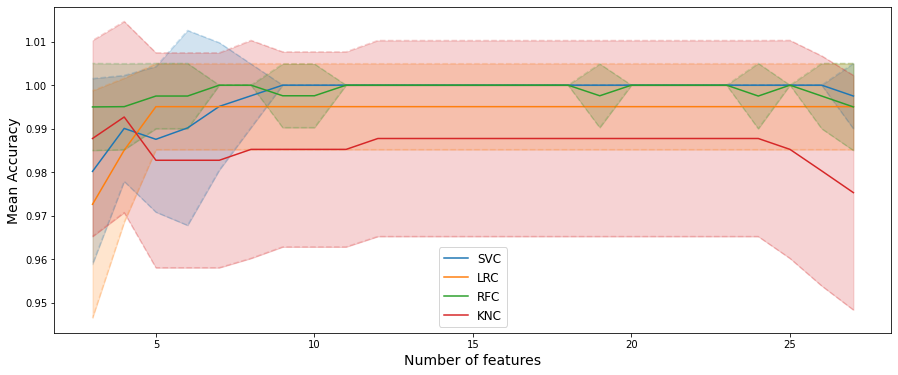

In [16]:
plt.figure(figsize=(15, 6))

color_list = COLOR_LIST
color_count = 0
for k, v in save_all_results.items():
    
    save_mean_acc = np.array([np.mean(sub_v["Accuracy"]) for sub_v in v])
    save_std_acc = np.array([np.std(sub_v["Accuracy"]) for sub_v in v])
    feature_num = np.array([sub_v["NumFeatures"] for sub_v in v])
    feature_names = [sub_v["Features"] for sub_v in v]
    
    best_idx = np.argsort(save_mean_acc)[-1]
    
    print("Best Accuracy for model", k, "=", np.round(save_mean_acc[best_idx], 4), 
          "+/-", np.round(save_std_acc[best_idx], 4), 
          "with number of features of", feature_num[best_idx])
    print("Best columns:", feature_names[best_idx])
    print()
    
    plt.plot(feature_num, save_mean_acc, label=k, color=color_list[color_count])
    plt.plot(feature_num, save_mean_acc + save_std_acc, 
             alpha=0.2, linestyle="--", color=color_list[color_count])
    plt.plot(feature_num, save_mean_acc - save_std_acc, 
             alpha=0.2, linestyle="--", color=color_list[color_count])
    plt.fill_between(feature_num, 
                     save_mean_acc - save_std_acc, 
                     save_mean_acc + save_std_acc, 
                     color=color_list[color_count], alpha=0.2)
    
    color_count += 1
    
plt.xlabel("Number of features", fontsize=14)
plt.ylabel("Mean Accuracy", fontsize=14)
plt.legend(fontsize=12)

plt.show()

Best Kappa for model SVC = 1.0 +/- 0.0 with number of features of 15
Best columns: age bp sg al su bgr bu sc sod pot hemo pcv wc rbc_nan pc_nan

Best Kappa for model LRC = 0.9894 +/- 0.0212 with number of features of 15
Best columns: age bp sg al su bgr bu sc sod pot hemo pcv wc rbc_normal htn_yes

Best Kappa for model RFC = 1.0 +/- 0.0 with number of features of 15
Best columns: age bp sg al su bgr bu sc sod pot pcv wc rc rbc_normal pc_nan

Best Kappa for model KNC = 0.9849 +/- 0.0454 with number of features of 4
Best columns: sg rbc_normal pc_normal htn_yes



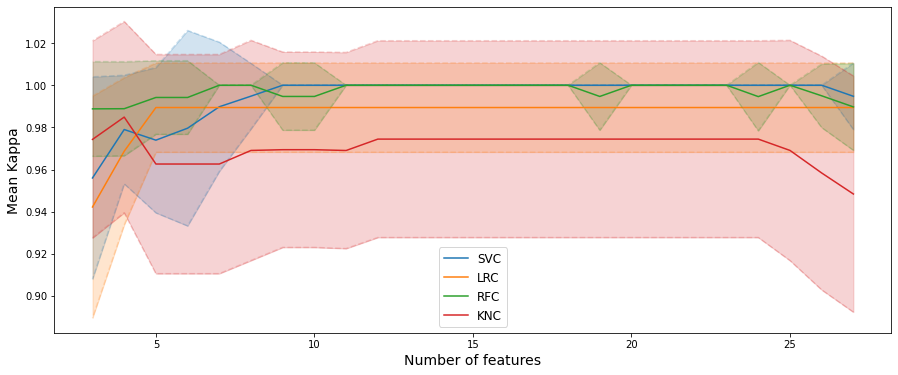

In [17]:
plt.figure(figsize=(15, 6))

color_list = COLOR_LIST
color_count = 0
for k, v in save_all_results.items():
    
    save_mean_kappa = np.array([np.mean(sub_v["Kappa"]) for sub_v in v])
    save_std_kappa = np.array([np.std(sub_v["Kappa"]) for sub_v in v])
    feature_num = np.array([sub_v["NumFeatures"] for sub_v in v])
    feature_names = [sub_v["Features"] for sub_v in v]
    
    best_idx = np.argsort(save_mean_kappa)[-1]
    
    print("Best Kappa for model", k, "=", np.round(save_mean_kappa[best_idx], 4), 
          "+/-", np.round(save_std_kappa[best_idx], 4), 
          "with number of features of", feature_num[best_idx])
    print("Best columns:", feature_names[best_idx])
    print()
    
    plt.plot(feature_num, save_mean_kappa, label=k, color=color_list[color_count])
    plt.plot(feature_num, save_mean_kappa + save_std_kappa, 
             alpha=0.2, linestyle="--", color=color_list[color_count])
    plt.plot(feature_num, save_mean_kappa - save_std_kappa, 
             alpha=0.2, linestyle="--", color=color_list[color_count])
    plt.fill_between(feature_num, 
                     save_mean_kappa - save_std_kappa, 
                     save_mean_kappa + save_std_kappa, 
                     color=color_list[color_count], alpha=0.2)
    
    color_count += 1
    
plt.xlabel("Number of features", fontsize=14)
plt.ylabel("Mean Kappa", fontsize=14)
plt.legend(fontsize=12)

plt.show()